# Загрузка Pandas и очистка данных

In [285]:
import pandas as pd
import numpy as np
import ast
from datetime import datetime as dt
import nltk
from collections import Counter

In [286]:
df = pd.read_csv('https://lms.skillfactory.ru/assets/courseware/v1/c00e440dce1926e20bcf7b959cbeebbb/asset-v1:Skillfactory+DST-PRO+15APR2020+type@asset+block/main_task_new.csv')

In [287]:
# Filling NANs in 'Number of Reviews' and making feature of them (last seems senseless, but I feel to lazy to check)
df['Number_of_Reviews_isNAN'] = pd.isna(df['Number of Reviews']).astype('uint8')
df['Number of Reviews'].fillna(0, inplace=True)

In [288]:
# Making dummy variables of 'Cuisine Style' and counting them
cuisines = []

def list_len(list_as_str):
    """
    Counts values in list represented as string.

    Parameters:
        list_as_str (str): List of single-quoted strings represented as string in Python syntax.
    
    Returns:
        int: Number of values in list.
    """

    return len(list_as_str.strip('[]').replace("'", "").split(', '))

def get_cuisines_list(list_as_str):
    """
    Extends the 'cuisines' list with the content of list represented as string.

    Parameters:
        list_as_str (str): List of single-quoted strings represented as string in Python syntax.
    
    Returns:
        None
    """

    cuisines.extend(list_as_str.strip('[]').replace("'", "").split(', '))

df['cuisine_style_count'] = df['Cuisine Style'].fillna('1').apply(list_len)

df['Cuisine Style'].dropna().apply(get_cuisines_list)

cuisines = set(cuisines)
cuisines.add('cuisine_style_is_nan') # separate feature for NANs
for cuisine in set(cuisines):
    df[cuisine] = df['Cuisine Style'].fillna('cuisine_style_is_nan').str.contains(cuisine).astype('uint8')

/var/folders/w2/vwdl1vy167l15y0bhwy601kjhbgjpc/T/ipykernel_84358/28530136.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cuisine] = df['Cuisine Style'].fillna('cuisine_style_is_nan').str.contains(cuisine).astype('uint8')


In [289]:
# Distributing 'Ranking' by it's part of maximum value for each 'City' so it may be compared between cities
df['ranking_part_of_max'] = df['Ranking'] / df['City'].map(df.groupby(['City'])['Ranking'].max())

/var/folders/w2/vwdl1vy167l15y0bhwy601kjhbgjpc/T/ipykernel_84358/606499753.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ranking_part_of_max'] = df['Ranking'] / df['City'].map(df.groupby(['City'])['Ranking'].max())


In [290]:
# top10_cities = df['City'].value_counts()[0:10].index
# df['City TOP 2'] = df['City'].isin(['London', 'Paris'])
# df['City TOP 10'] = df['City'].isin(top10_cities)

# Making dummy variables of 'City'
df = pd.get_dummies(df, columns=[ 'City',], dummy_na=True)

In [291]:
# Converting 'Price Range' to number values
prices = {
    '$': 1, 
    '$$ - $$$': 2, 
    '$$$$': 3, 
}

# NANs getting filled with most frequent value that is 2
df['Price Range'] = df['Price Range'].map(prices, na_action='ignore').fillna(2)

In [292]:
# Making features of first and last review dates counting number 
# of days from Jan 1 2000 (before TripAdvisor were founded)
zero_date = dt(2000, 1, 1, 0, 0, 0)

def get_review_date(list_as_str, f=max):
    """
    Extracting date from list of reviews represented as string 
    and finding maximum or minimum date (or somthing else).

    Parameters:
        list_as_str (str): List of list of review and it's date 
        represented as string in Python syntax.
        f (callable): Function to apply to list of dates. Default: max.
    
    Returns:
        datetime: Date of last (f=max) or first (f=min) review date.
    """

    # this check for float here is just to run this function in kaggle version of notebook
    if type(list_as_str) == float:
        list_as_str = 'nan'

    list_as_str = list_as_str.replace('nan', "''")

    if len(list_as_str) > 8:
        try:
            _, dates_string_list = ast.literal_eval(list_as_str)
            return f([dt.strptime(x, '%m/%d/%Y') for x in dates_string_list])
        except ValueError:
            print(list_as_str)
    return zero_date

df['first_review'] = (df['Reviews'].apply(get_review_date, args=(min,)) - zero_date).dt.days
df['last_review'] = (df['Reviews'].apply(get_review_date) - zero_date).dt.days

In [ ]:
# Making features with counts of positive and nagative words in reviews.
# It takes half an hour on my machine to compute. It makes prediction in this 
# notebook better for ~0.1 percent. But makes worse prediction in kaggle version.

# Meaningless words to remove from reviews.
stopwords = nltk.corpus.stopwords.words('english')

review_words = []
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+') # Splits by words

def get_words(list_as_str, tokenizer, to_list=None, ):
    """
    Extracts valueable words from from list of reviews represented as string.

    Parameters:
        list_as_str (str): List of list of review and it's date represented as 
        string in Python syntax.
        tokenizer (tokenizer): Instance of RegexpTokenizer class to split string.
        to_list (list): List to save extracted words separately (if needed).
    
    Returns:
        dict: Couner of extracted valueable words.
    """

    # this check for float here is just to run this function in kaggle version of notebook
    if type(list_as_str) == float:
        list_as_str = 'nan'

    list_as_str = list_as_str.replace('nan', "''")
    if len(list_as_str) > 8:
        try:
            words = []
            for review in ast.literal_eval(list_as_str)[0]:
                words.extend([x.lower() for x in tokenizer.tokenize(review) if x.lower() not in stopwords])
                if to_list is not None:
                    to_list.extend(words)
            return dict(Counter(words))
        except ValueError:
            pass
    return dict()

df['reviews_words'] = df['Reviews'].apply(get_words, args=(tokenizer, ), )

# Lists of opinion words.
positive_words = nltk.corpus.opinion_lexicon.positive()
negative_words = nltk.corpus.opinion_lexicon.negative()

def count_opinion_words(words_count_dict, opinion_words_list):
    """
    Counts opinion words in dict with counted words.

    Parameters:
        words_count_dict (dict): Counter of words.
        opinion_words_list (list): List of opinion words to count.
    
    Returns:
        int: Number of words in words_count_dict contained in opinion_words_list.
    """
    
    return sum([count for word, count in words_count_dict.items() if word in opinion_words_list])

df['positive_words_count'] = df['reviews_words'].apply(count_opinion_words, args=(positive_words, ), )
df['negative_words_count'] = df['reviews_words'].apply(count_opinion_words, args=(negative_words, ), )

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [ ]:
RANDOM_SEED = 42

In [ ]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop([
    'Restaurant_id', 
    'Rating', 
    'Cuisine Style', 
    'Reviews', 
    'URL_TA', 
    'ID_TA', 
    # 'City', 
    'Ranking', 
    'reviews_words', 
], axis = 1)
y = df['Rating']

In [ ]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [ ]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Создаём, обучаем и тестируем модель

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20095187499999997


<AxesSubplot:>

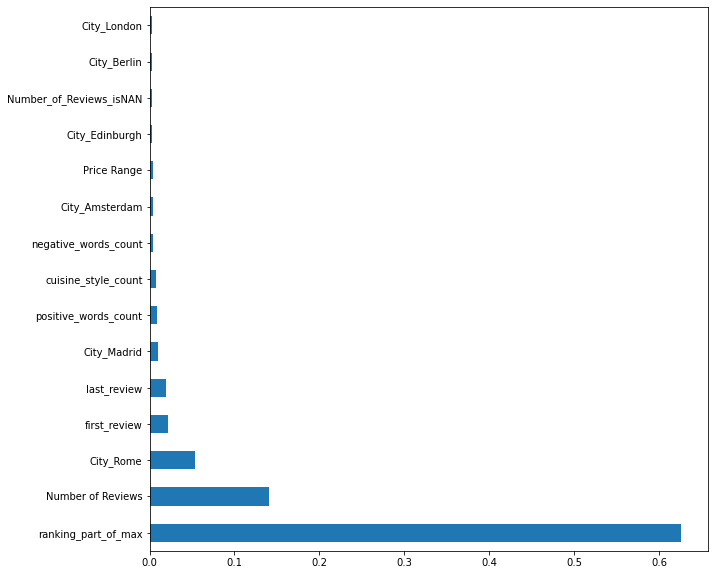

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')